In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split
import nibabel as nib
import numpy as np
import random
import torchvision.transforms.functional as FF
from PIL import Image
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DATASET
DATASET_DIR = 'H:/Meu Drive/MESTRADO/MODELO/MODEL'
os.makedirs(DATASET_DIR, exist_ok=True)

class ZScoreNormalize:
    def __call__(self, img):
        mean = img.mean()
        std = img.std()
        return (img - mean) / std
    

# LOADING THE PREVIOUSLY SAVED DATASET - IS NECESSARY TO WRITE THE CODE AGAIN
class RandomAffineWithIndependentProbabilities:
    def __init__(self, rotate_prob, translate_prob, scale_prob, rotate_range, translate_range, scale_range):
        self.rotate_prob = rotate_prob
        self.translate_prob = translate_prob
        self.scale_prob = scale_prob
        self.rotate_range = rotate_range
        self.translate_range = translate_range
        self.scale_range = scale_range

    def __call__(self, img):
        if random.random() < self.rotate_prob:
            angle = random.uniform(*self.rotate_range)
            img = FF.rotate(img, angle)

        if random.random() < self.translate_prob:
            translate_x = random.randint(-self.translate_range[0], self.translate_range[0])
            translate_y = random.randint(-self.translate_range[1], self.translate_range[1])
            img = FF.affine(img, angle=0, translate=(translate_x, translate_y), scale=1, shear=0)

        if random.random() < self.scale_prob:
            scale_factor = random.uniform(*self.scale_range)
            img = FF.affine(img, angle=0, translate=(0, 0), scale=scale_factor, shear=0)

        return img

augment = T.Compose([
    T.RandomApply([T.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1))], p=0.1),
])

transform = T.Compose([
   T.Resize((112, 112), interpolation=InterpolationMode.NEAREST), 
   ZScoreNormalize(),
    
])

resize = T.Compose([
    T.Resize((112, 112), interpolation=InterpolationMode.NEAREST),
])

class MedicalImageDataset(Dataset):
    def __init__(self, adc_paths, dwi_paths, mask_paths, transform=None, augment=None, resize=None):
        self.adc_paths = adc_paths
        self.dwi_paths = dwi_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.augment = augment  
        self.resize = resize

        self.rand_affine = RandomAffineWithIndependentProbabilities(
            rotate_prob=0.70, 
            translate_prob=0.70,
            scale_prob=0.70,
            rotate_range=(-10, 10),  
            translate_range=(6, 6),  
            scale_range=(1, 1) 
        )

        self.cache = {}

    def __len__(self):
        return len(self.adc_paths) * 16

    def __getitem__(self, idx):
        patient_idx = idx // 16
        slice_offset = idx % 16

        if idx in self.cache:
            return self.cache[idx]

        adc_image = nib.load(self.adc_paths[patient_idx]).get_fdata().astype(np.float32)
        dwi_image = nib.load(self.dwi_paths[patient_idx]).get_fdata().astype(np.float32)
        mask_image = nib.load(self.mask_paths[patient_idx]).get_fdata().astype(np.float32)


        mid_slice = adc_image.shape[2] // 2
        start_slice = mid_slice - 8

        adc_slice = adc_image[:, :, start_slice + slice_offset]
        dwi_slice = dwi_image[:, :, start_slice + slice_offset]
        mask_slice = mask_image[:, :, start_slice + slice_offset]

        adc_slice = np.expand_dims(adc_slice, axis=0) 
        dwi_slice = np.expand_dims(dwi_slice, axis=0)  
        mask_slice = np.expand_dims(mask_slice, axis=0)

        adc_slice_pil = Image.fromarray(adc_slice[0])  
        dwi_slice_pil = Image.fromarray(dwi_slice[0])  
        mask_slice_pil = Image.fromarray(mask_slice[0])

        ground_truth = T.ToTensor()(adc_slice_pil)
        mask_ground = T.ToTensor()(mask_slice_pil)
        
        angle = random.uniform(*self.rand_affine.rotate_range) if random.random() < self.rand_affine.rotate_prob else 0
        translate_x = random.randint(-self.rand_affine.translate_range[0], self.rand_affine.translate_range[0]) if random.random() < self.rand_affine.translate_prob else 0
        translate_y = random.randint(-self.rand_affine.translate_range[1], self.rand_affine.translate_range[1]) if random.random() < self.rand_affine.translate_prob else 0
        scale = random.uniform(*self.rand_affine.scale_range) if random.random() < self.rand_affine.scale_prob else 1.0

        adc_slice_pil = FF.affine(adc_slice_pil, angle=angle, translate=(translate_x, translate_y), scale=scale, shear=0)
        mask_slice_pil = FF.affine(mask_slice_pil, angle=angle, translate=(translate_x, translate_y), scale=scale, shear=0)


        adc_slice = T.ToTensor()(adc_slice_pil)
        dwi_slice = T.ToTensor()(dwi_slice_pil)
        mask_slice = T.ToTensor()(mask_slice_pil)

        if self.augment:
             adc_slice = self.augment(adc_slice)
        if self.transform:
             adc_slice = self.transform(adc_slice)
             dwi_slice = self.transform(dwi_slice)
             ground_truth = self.transform(ground_truth)
             mask_ground = self.resize(mask_ground)
             mask_slice = self.resize(mask_slice)

        self.cache[idx] = {'fixed': dwi_slice, 'moving': adc_slice, 'ground_truth': ground_truth, 'mask': mask_slice, 'mask_ground': mask_ground}
        
        return self.cache[idx]

def create_datasets(adc_paths, dwi_paths, mask_paths, transform=None, augment=None, resize=None):
    dataset = MedicalImageDataset(adc_paths, dwi_paths, mask_paths, transform=transform, augment=augment, resize=resize)
    length = len(dataset)
    train_size = int(0.7 * length)   
    val_size = int(0.2 * length)   
    test_size = length - train_size - val_size 
    return random_split(dataset, [train_size, val_size, test_size])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

adc_paths = [f"C:/Users/danny/OneDrive/Área de Trabalho/ESTAGIO/dataset/ISLES-2022/ISLES-2022/sub-strokecase{i:04d}/ses-0001/dwi/sub-strokecase{i:04d}_ses-0001_adc.nii.gz" for i in range(1, 251)]
dwi_paths = [f"C:/Users/danny/OneDrive/Área de Trabalho/ESTAGIO/dataset/ISLES-2022/ISLES-2022/sub-strokecase{i:04d}/ses-0001/dwi/sub-strokecase{i:04d}_ses-0001_dwi.nii.gz" for i in range(1, 251)]
mask_paths= [f"C:/Users/danny/OneDrive/Área de Trabalho/ESTAGIO/dataset/ISLES-2022/ISLES-2022/derivatives/sub-strokecase{i:04d}/ses-0001/sub-strokecase{i:04d}_ses-0001_msk.nii.gz" for i in range(1, 251)]

# LOADING THE DATASET
train_dataset = torch.load(os.path.join(DATASET_DIR, "TESTE 2/train_dataset.pt"))
test_dataset = torch.load(os.path.join(DATASET_DIR, "TESTE 2/test_dataset.pt"))
val_dataset = torch.load(os.path.join(DATASET_DIR, "TESTE 2/val_dataset.pt"))

train_dataset, val_dataset, test_dataset = create_datasets(adc_paths, dwi_paths, mask_paths, transform=transform, augment=augment, resize=resize)

In [16]:
# FILTERING TEST DATASET TO REMOVE SAMPLES WITH EMPTY MASKS (TO NOT AFFECT THE EVALUATION METRICS)
filtered_test_dataset = []
valid_ids = []

for i, sample in enumerate(test_dataset):
    mask = sample['mask']
    if mask.sum() != 0:
        filtered_test_dataset.append(sample)
        valid_ids.append(i)

print(f"Original test dataset size: {len(test_dataset)}")
print(f"Filtered test dataset size (non-empty masks): {len(filtered_test_dataset)}")

Original test dataset size: 400
Filtered test dataset size (non-empty masks): 208


In [17]:
# LOADING THE MODEL
class MODELCNN(nn.Module):
    def __init__(self):
        super(MODELCNN, self).__init__()
        
        # Feature extractor, entrada agora com 2 canais
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
 
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        dummy_input = torch.zeros(1, 2, 112, 112)
        with torch.no_grad():
            dummy_output = self.feature_extractor(dummy_input)
        flattened_size = dummy_output.view(1, -1).size(1)
        
        self.regression_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened_size, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 6)
        )

    def forward(self, fixed, moving):
        combined = torch.cat((fixed, moving), dim=1)
        features = self.feature_extractor(combined)
        transformation_params = self.regression_net(features)
        theta = transformation_params.view(-1, 2, 3)

        grid = F.affine_grid(theta, fixed.size(), align_corners=False)
        warped = F.grid_sample(moving, grid, align_corners=False)
        warped = warped[:, 0:1, :, :]

        return warped, theta



SAVE_DIR = 'H:/Meu Drive/MESTRADO/MODELO/ULTIMO TESTE/TESTE 2'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MODELCNN().to(device)
MODEL_PATH = os.path.join(SAVE_DIR, 'FINALMODEL3.pth')
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

C:\Users\danny\AppData\Local\Temp\ipykernel_31680\3429411408.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


MODELCNN(
  (feature_extractor): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1,

 12%|█▏        | 24/208 [00:05<00:15, 11.73it/s]

Plotting sample 25 (Index in Test Dataset)


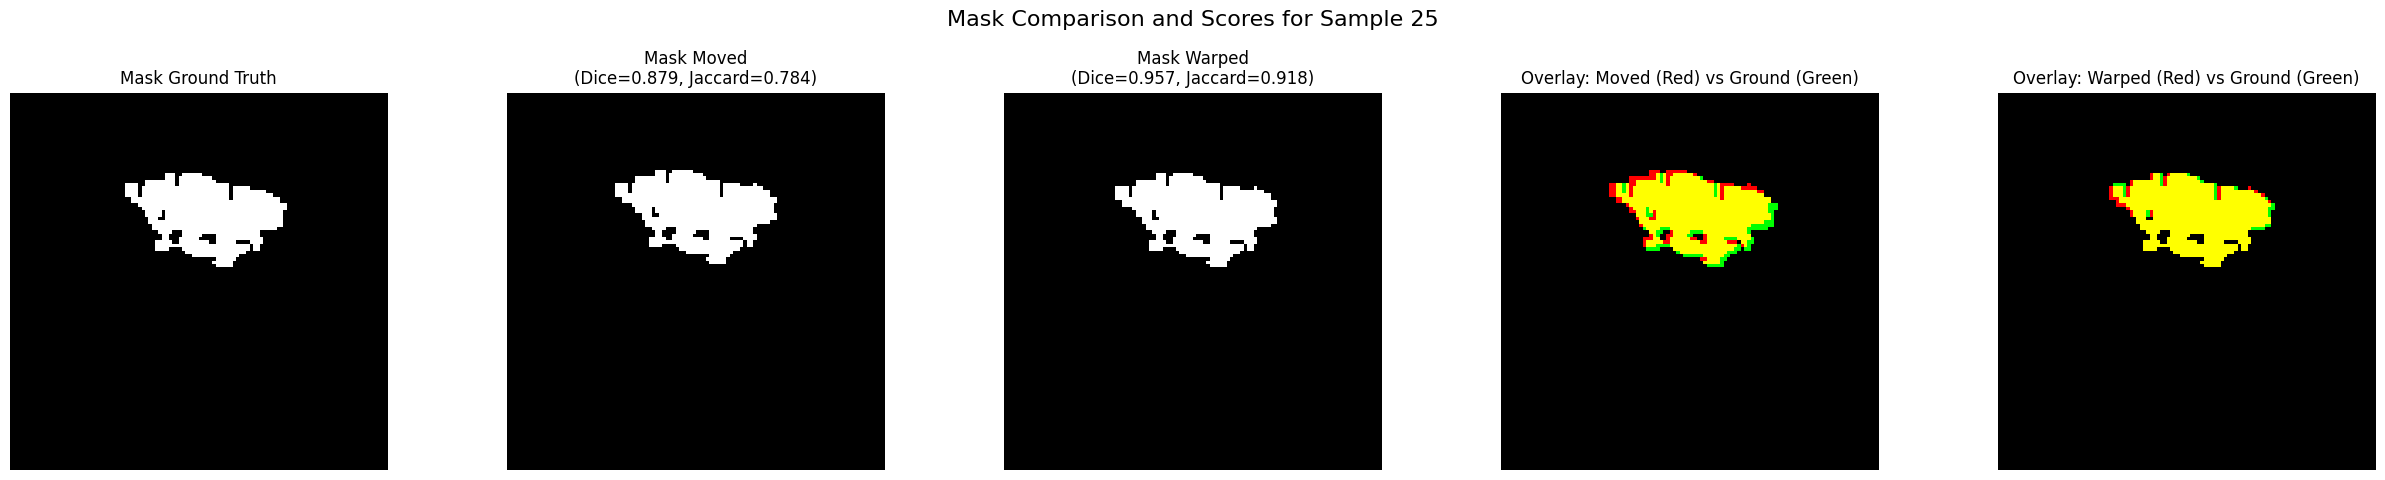

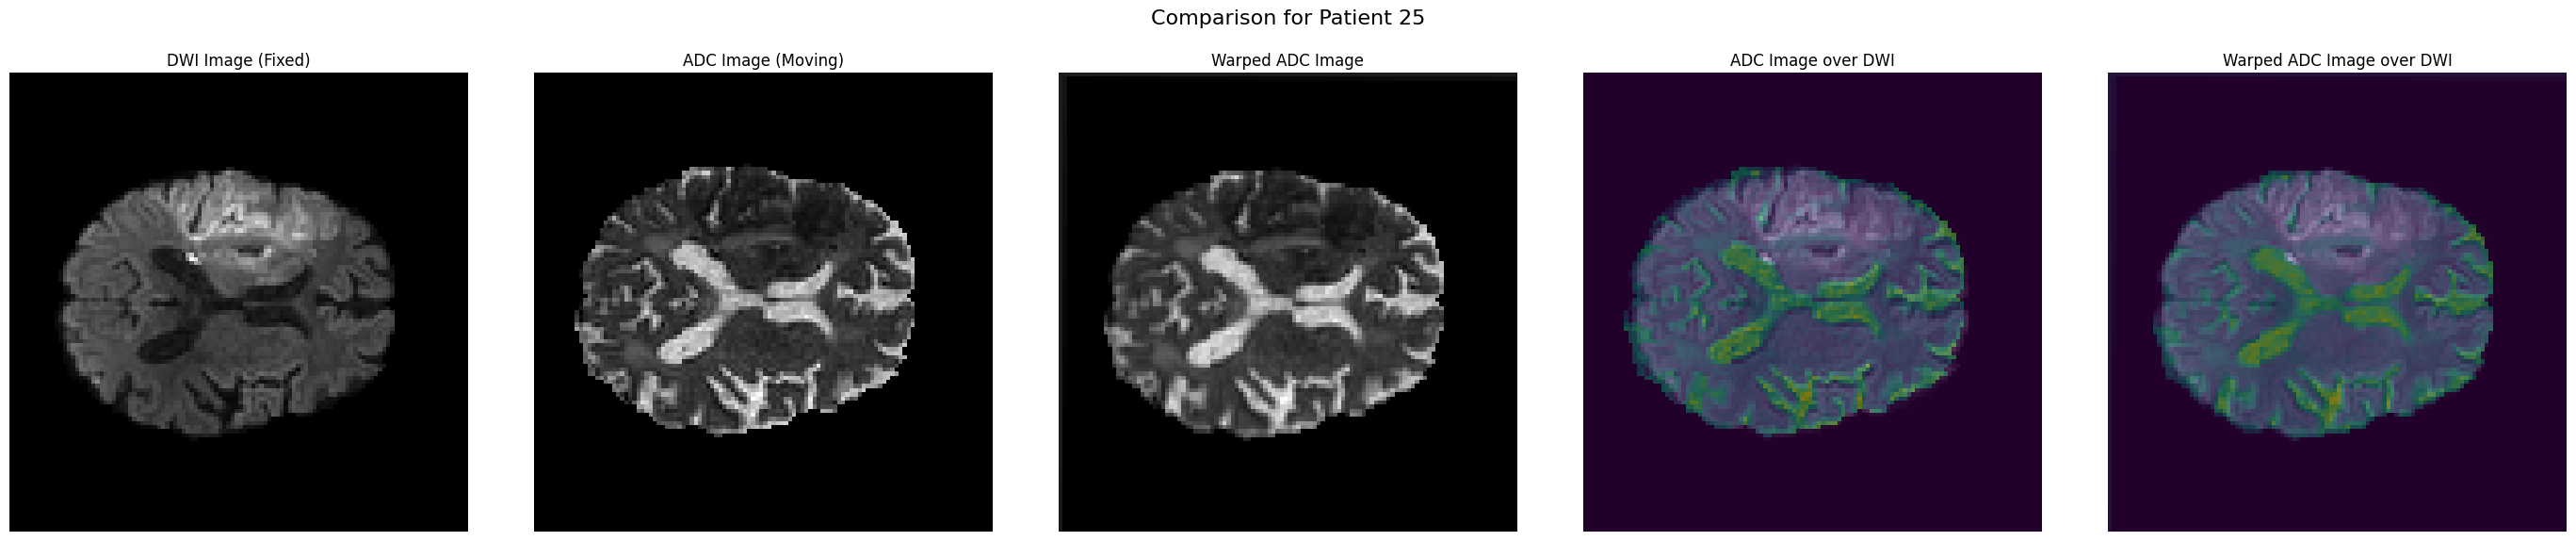

 17%|█▋        | 36/208 [00:07<00:16, 10.69it/s]

Plotting sample 37 (Index in Test Dataset)


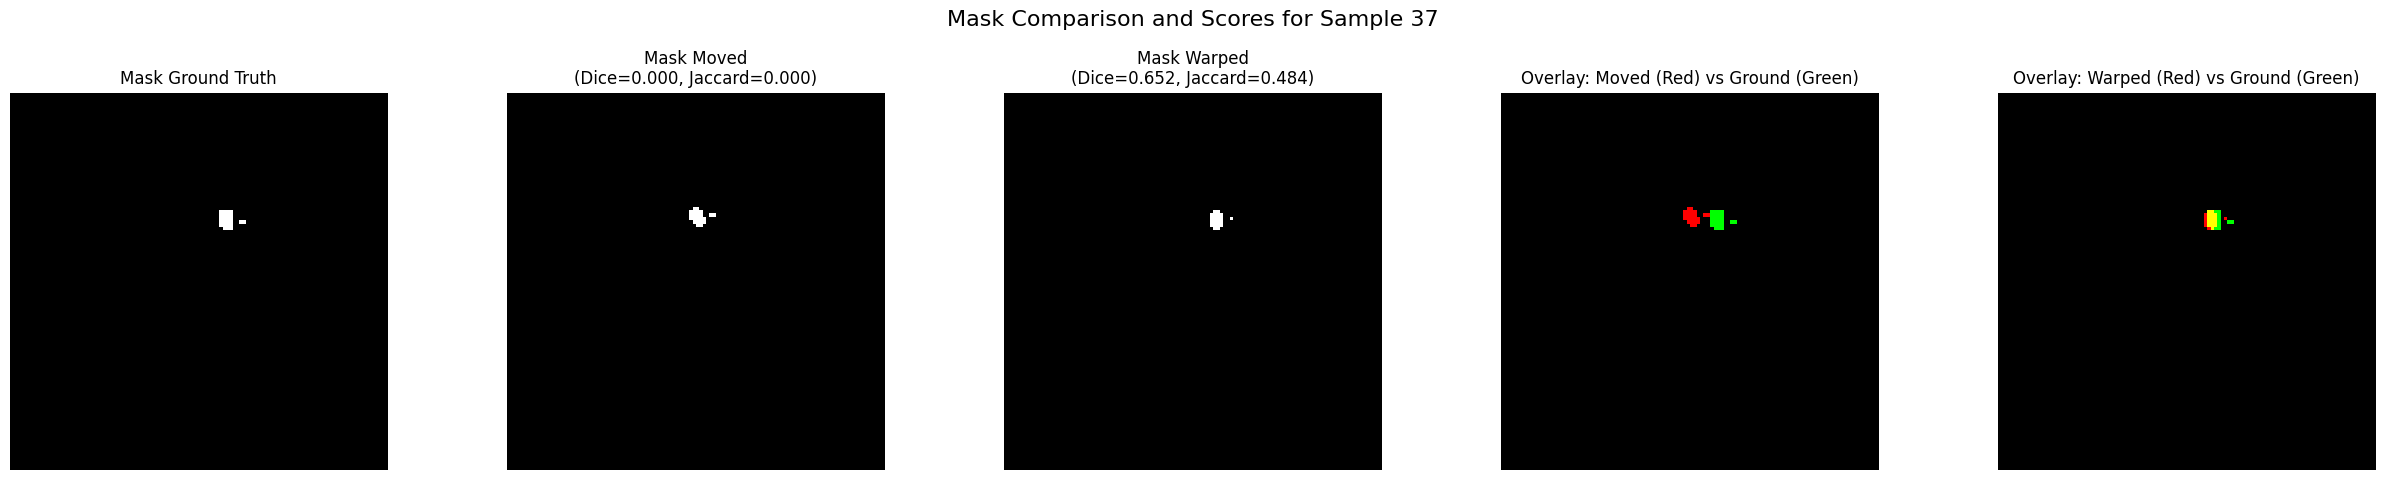

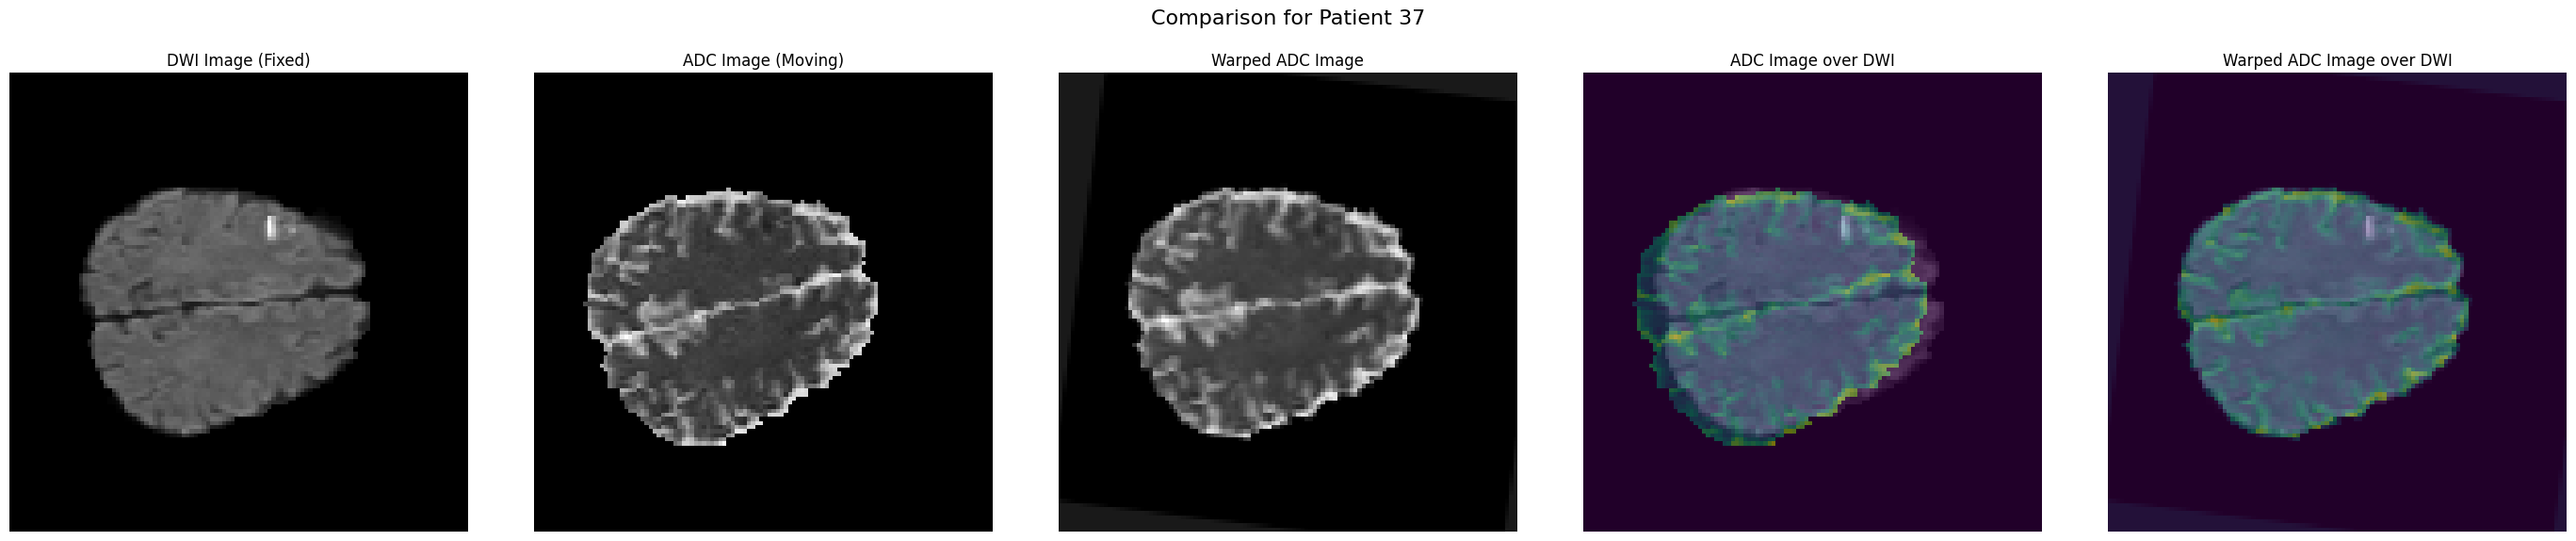

 20%|██        | 42/208 [00:09<00:32,  5.18it/s]

Plotting sample 42 (Index in Test Dataset)


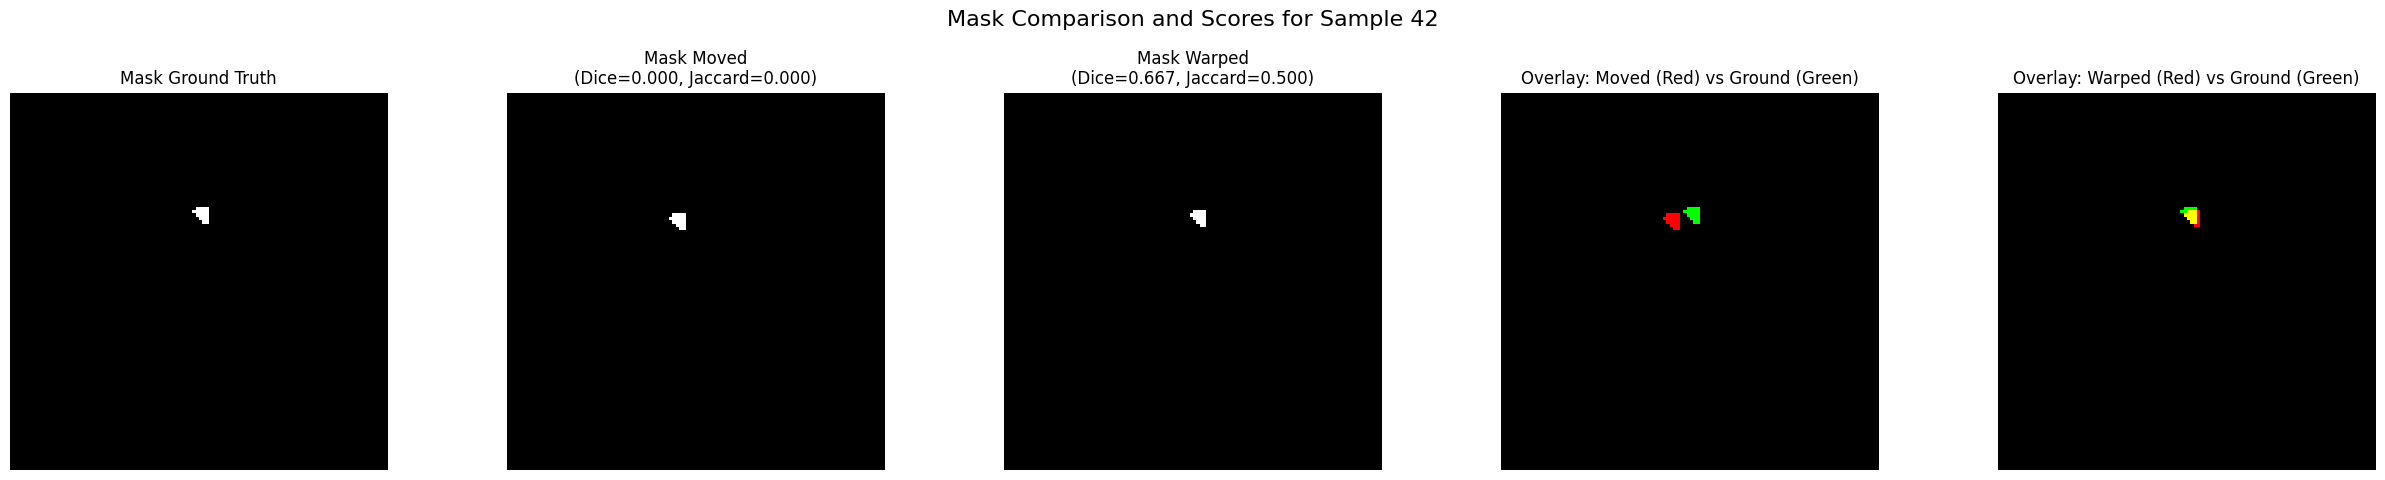

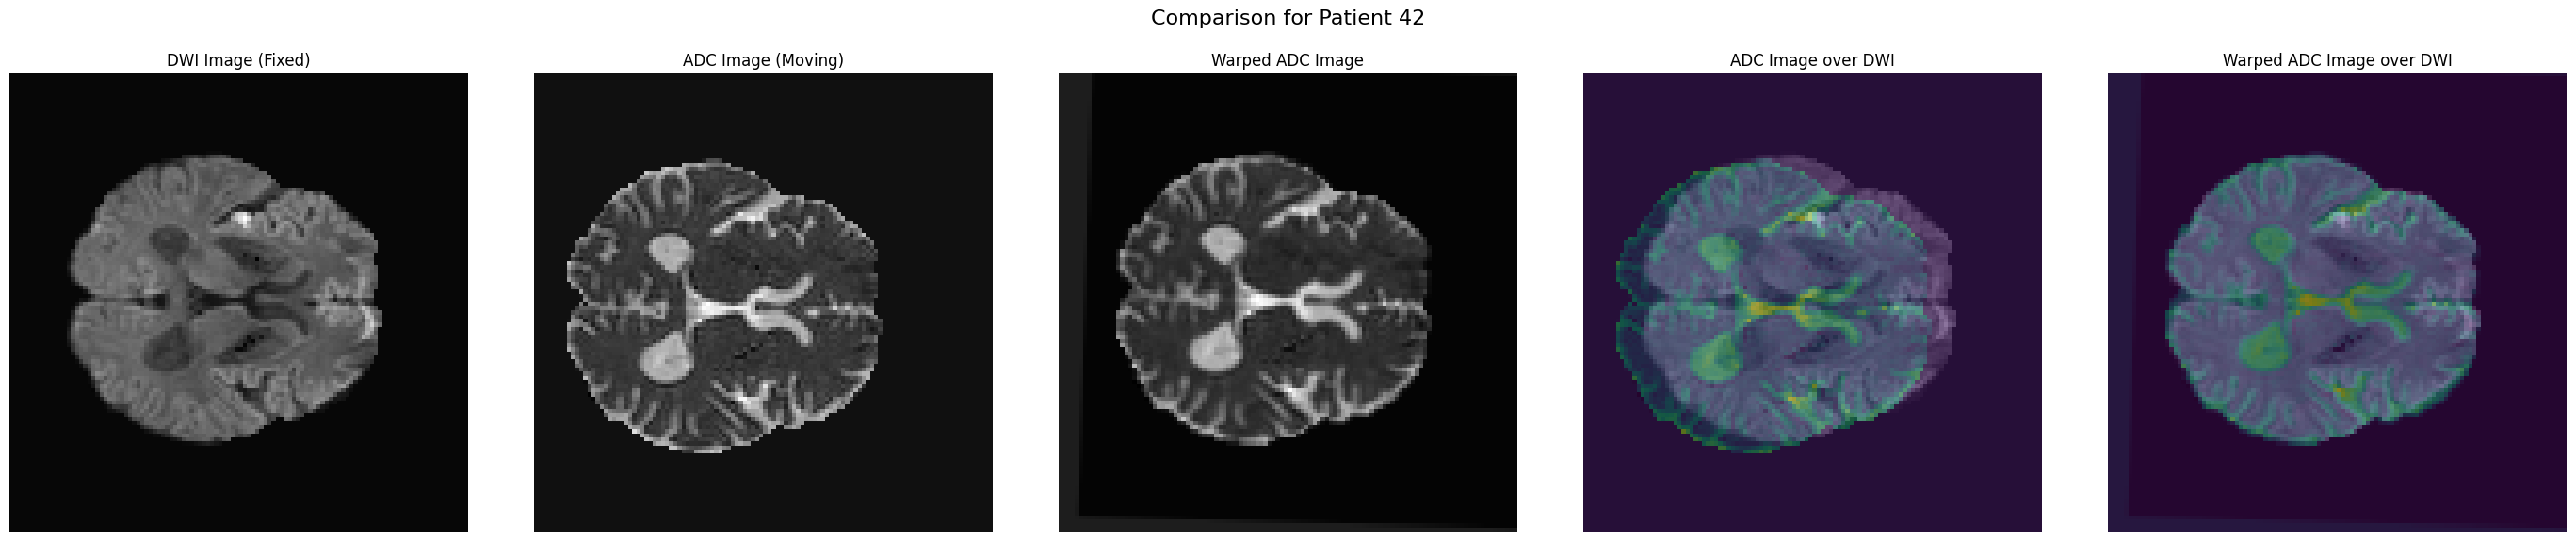

100%|██████████| 208/208 [00:19<00:00, 10.84it/s]

Dice/Jaccard - Ground vs Ground, Moved, Warped
       Patient_ID  Dice_Ground  Jaccard_Ground  Dice_Moved  Jaccard_Moved  \
count  208.000000        208.0           208.0  208.000000     208.000000   
mean   103.500000          1.0             1.0    0.390384       0.308676   
std     60.188592          0.0             0.0    0.346249       0.314194   
min      0.000000          1.0             1.0    0.000000       0.000000   
25%     51.750000          1.0             1.0    0.000000       0.000000   
50%    103.500000          1.0             1.0    0.333333       0.200000   
75%    155.250000          1.0             1.0    0.713946       0.555186   
max    207.000000          1.0             1.0    1.000000       1.000000   

       Hausdorff_Moved   NCC_Moved  Dice_Warped  Jaccard_Warped  \
count       207.000000  208.000000   208.000000      208.000000   
mean          4.540871    0.712430     0.815885        0.737215   
std           3.911497    0.121918     0.226376        0.2

In [20]:
import torch
import torch.nn.functional as F
import pandas as pd
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.metrics import structural_similarity as compare_ssim
from sklearn.metrics import jaccard_score
import numpy as np
from scipy.spatial.distance import directed_hausdorff

# TESTING THE MODEL AND EVALUATING THE MASKS
test_indices = [25, 37, 42, 239, 223]
results = []
start_time = time.time()

def hausdorff95(mask1, mask2):
    mask1_coords = np.argwhere(mask1.cpu().numpy() > 0)
    mask2_coords = np.argwhere(mask2.cpu().numpy() > 0)

    if len(mask1_coords) == 0 or len(mask2_coords) == 0:
        return np.nan

    d1 = directed_hausdorff(mask1_coords, mask2_coords)[0]
    d2 = directed_hausdorff(mask2_coords, mask1_coords)[0]
    return max(np.percentile([d1], 95), np.percentile([d2], 95))

def normalized_cross_correlation(img1, img2):
    x = img1.view(-1).cpu().numpy()
    y = img2.view(-1).cpu().numpy()
    return np.corrcoef(x, y)[0, 1] if x.std() > 0 and y.std() > 0 else 0

def dice_score(mask1, mask2):
    mask1_np = mask1.view(-1).detach().cpu().numpy()
    mask2_np = mask2.view(-1).detach().cpu().numpy()

    sum1 = mask1_np.sum()
    sum2 = mask2_np.sum()

    if sum1 == 0 and sum2 == 0:
        return 1

    intersection = (mask1_np * mask2_np).sum()
    
    denominator = sum1 + sum2 
    return (2. * intersection) / denominator

def jaccard_index(mask1, mask2):
    mask1 = mask1.view(-1).detach().cpu().numpy().astype(bool)
    mask2 = mask2.view(-1).detach().cpu().numpy().astype(bool)
    return jaccard_score(mask1, mask2, zero_division=1)

mask_results = []

for i, sample in enumerate(tqdm(filtered_test_dataset)):
    fixed = sample['fixed'].to(device)
    moving = sample['moving'].to(device)
    ground = sample['ground_truth'].to(device)
    mask = sample['mask'].to(device)
    mask_ground = sample['mask_ground'].to(device)

    warped_tensor, theta = model(fixed.unsqueeze(0), moving.unsqueeze(0))
    warped_tensor = warped_tensor.detach().squeeze(0)
    theta = theta.detach().squeeze(0)

    mask = torch.nan_to_num(mask, nan=0.0)
    mask_ground = torch.nan_to_num(mask_ground, nan=0.0)

    mask_unsqueezed = mask.unsqueeze(0).float()
    mask_ground_unsqueezed = mask_ground.unsqueeze(0).float()
    grid_mask = F.affine_grid(theta.unsqueeze(0), mask_ground_unsqueezed.size(), align_corners=False)
    warped_mask = F.grid_sample(mask_unsqueezed, grid_mask, mode='nearest', align_corners=False)
    warped_mask = warped_mask.squeeze(0)

    # METRICS CALCULATION
    dice_gw = dice_score(mask_ground, warped_mask)
    jaccard_gw = jaccard_index(mask_ground, warped_mask)
    hausdorff_gw = hausdorff95(mask_ground, warped_mask)

    dice_gm = dice_score(mask_ground, mask)
    jaccard_gm = jaccard_index(mask_ground, mask)
    hausdorff_gm = hausdorff95(mask_ground, mask)

    ncc_moved = normalized_cross_correlation(ground, moving)
    ncc_warped = normalized_cross_correlation(ground, warped_tensor)

    mask_results.append({
        'Patient_ID': i,
        'Dice_Ground': dice_score(mask_ground, mask_ground),
        'Jaccard_Ground': jaccard_index(mask_ground, mask_ground),
        'Dice_Moved': dice_gm,
        'Jaccard_Moved': jaccard_gm,
        'Hausdorff_Moved': hausdorff_gm,
        'NCC_Moved': ncc_moved,
        'Dice_Warped': dice_gw,
        'Jaccard_Warped': jaccard_gw,
        'Hausdorff_Warped': hausdorff_gw,
        'NCC_Warped': ncc_warped,
    })

    # PLOTTING THE RESULTS
    if i in test_indices:
        print(f"Plotting sample {i} (Index in Test Dataset)")
        mask_ground_np = mask_ground.squeeze().cpu().numpy()
        mask_moved_np = mask.squeeze().cpu().numpy()     
        mask_warped_np = warped_mask.squeeze().cpu().numpy() 

        overlay_moved = np.zeros((*mask_ground_np.shape, 3), dtype=np.float32)
        overlay_warped = np.zeros((*mask_ground_np.shape, 3), dtype=np.float32)

        overlay_moved[:, :, 1] = mask_ground_np  
        overlay_moved[:, :, 0] = mask_moved_np   
        overlay_warped[:, :, 1] = mask_ground_np 
        overlay_warped[:, :, 0] = mask_warped_np 

        fig_mask, axes_mask = plt.subplots(1, 5, figsize=(25, 5))
        fig_mask.suptitle(f'Mask Comparison and Scores for Sample {i}', fontsize=16)

        axes_mask[0].imshow(mask_ground_np, cmap='gray')
        axes_mask[0].set_title('Mask Ground Truth')
        axes_mask[0].axis('off')
        axes_mask[1].imshow(mask_moved_np, cmap='gray')
        axes_mask[1].set_title(f'Mask Moved\n(Dice={dice_gm:.3f}, Jaccard={jaccard_gm:.3f})') 
        axes_mask[1].axis('off')
        axes_mask[2].imshow(mask_warped_np, cmap='gray')
        axes_mask[2].set_title(f'Mask Warped\n(Dice={dice_gw:.3f}, Jaccard={jaccard_gw:.3f})')
        axes_mask[2].axis('off')
        axes_mask[3].imshow(overlay_moved)
        axes_mask[3].set_title('Overlay: Moved (Red) vs Ground (Green)')
        axes_mask[3].axis('off')
        axes_mask[4].imshow(overlay_warped)
        axes_mask[4].set_title('Overlay: Warped (Red) vs Ground (Green)')
        axes_mask[4].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show() 

        # PLOTTING THE IMAGES AND OVERLAYS
        adc_image = moving.squeeze().cpu().numpy()
        dwi_image = fixed.squeeze().cpu().numpy()
        ground_image = ground.squeeze().cpu().numpy()
        warped_image = warped_tensor.squeeze().cpu().numpy()

        fig, axes = plt.subplots(1, 5, figsize=(28, 6))
        fig.suptitle(f'Comparison for Patient {i}', fontsize=16)

        axes[0].imshow(dwi_image, cmap='gray')
        axes[0].set_title('DWI Image (Fixed)')
        axes[0].axis('off')

        axes[1].imshow(adc_image, cmap='gray')
        axes[1].set_title('ADC Image (Moving)')
        axes[1].axis('off')

        axes[2].imshow(warped_image, cmap='gray')
        axes[2].set_title('Warped ADC Image')
        axes[2].axis('off')

        axes[3].imshow(dwi_image, cmap='gray')
        axes[3].imshow(adc_image, alpha=0.5, cmap='viridis')
        axes[3].set_title('ADC Image over DWI')
        axes[3].axis('off')

        axes[4].imshow(dwi_image, cmap='gray')
        axes[4].imshow(warped_image, alpha=0.5, cmap='viridis')
        axes[4].set_title('Warped ADC Image over DWI')
        axes[4].axis('off')
        

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

df_masks = pd.DataFrame(mask_results)
print("Dice/Jaccard - Ground vs Ground, Moved, Warped")
print(df_masks.describe())

In [ ]:
#EXEMPLE OF RUNNING THE MODEL AND SAVING THE RESULTS AS NIFTI FILES

import torch
import torch.nn.functional as F
import os
import nibabel as nib
import numpy as np
from tqdm import tqdm

output_dir = "output_nii"
os.makedirs(output_dir, exist_ok=True)

def save_nii(tensor, path):
    data = tensor.squeeze().cpu().numpy().astype(np.float32)
    nii = nib.Nifti1Image(data, affine=np.eye(4))
    nib.save(nii, path)

for i, sample in enumerate(tqdm(filtered_test_dataset)):
    fixed = sample['fixed'].to(device)
    moving = sample['moving'].to(device)

    warped_tensor, _ = model(fixed.unsqueeze(0), moving.unsqueeze(0))
    warped_tensor = warped_tensor.detach().squeeze(0)

    patient_dir = os.path.join(output_dir, f"Patient_{i}")
    os.makedirs(patient_dir, exist_ok=True)
    save_nii(warped_tensor, os.path.join(patient_dir, "warped.nii.gz"))
